In [1]:
# https://youtu.be/w8yWXqWQYmU

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

my_file = "/Users/prashantgulati/Google_Drive/personal/dev/python/mnist/digit-recognizer/train.csv"

data = pd.read_csv(my_file)
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
data = np.array(data)
m, n = data.shape
#42000 rows of 785 pixels
print("Data shape: ", data.shape)

np.random.shuffle(data)

#785 rows for 42000 instances
data_dev = data[0:1000].T
# First column is label
Y_dev = data_dev[0]
#784 rows for 1000 instances. First column is label
X_dev = data_dev[1:n]
# I'm not sure why is was necessary. I suppose divided by 255 because that's the range of numbers. And multiplication with smaller numbers is easier
X_dev = X_dev / 255

#
data_train = data[1000:m].T
Y_train = data_train[0]
#784 rows for 42000 instances. First column is label
X_train = data_train[1:n]
print("Before division: ", X_train[510])
X_train = X_train/ 255
_,m_train = X_train.shape

print("X_train shape: ", _, m_train)
print("After division: ",X_train[510])


Data shape:  (42000, 785)
Before division:  [  0   0   0 ... 253   0   0]
X_train shape:  784 41000
After division:  [0.         0.         0.         ... 0.99215686 0.         0.        ]


In [3]:
def init_params():
    # want these numbers to be between -0.5 and 0.5. I'm not sure why
    W1 = np.random.rand(10,784) - 0.5
    b1 = np.random.rand(10,1) - 0.5
    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    
    # compress a 784 rows of data into 10 rows for m instances
    Z1 = W1.dot(X) + b1
    # What if we tried different algorithms here?
    A1 = ReLU(Z1)

    # process 10 rows of data into 10 rows for m instances
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    return Z > 0

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    # how much was the activated last layer prediction off from the label. Generate a matrix the size of Z2/A2
    dZ2 = A2 - one_hot_Y
    #how much of that was because of the weight. Take an average of the dot product of DZ and the previous layer transposed
    dW2 = (1/m)*dZ2.dot(A1.T)
    #how much of that was because of the bias. Take an average of the sum of DZs
    db2 = (1/m)*np.sum(dZ2)
    
    # how much was the activated first layer prediction off. Generate a matrix the size of Z1/A1. 
    #We undo the first layer activation function, but not the second one?
    dZ1 = W2.T.dot(dZ2)*deriv_ReLU(Z1)
    #how much of that was because of the weight. Take an average of the dot product of DZ and the previous layer transposed
    dW1 = (1/m)*dZ1.dot(X.T)
    #how much of that was because of the bias. Take an average of the sum of DZs
    db1 = (1/m)*np.sum(dZ1)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2
    

In [4]:
#for an array, return which position had the max value
def get_predictions(A2):
    return np.argmax(A2,0)

# compare predictions array to labels array
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X,Y, iterations, alpha):
    # initialize weights and biases randomly
    W1,b1,W2,b2 = init_params()
    for i in range(iterations):
        # Run all of X, all m of its instances through the network. Get the values for the first and second layers
        Z1,A1,Z2,A2 = forward_prop(W1,b1,W2,b2,X)
        # Run X, Y the weights and the first and second layers to determine how far off we were from the labels
        dW1,db1, dW2, db2 = backward_prop(Z1,A1, Z2, A2, W1, W2, X, Y)
        # Update weights and biases
        W1,b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i%10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2

In [5]:
# can try changing iterations and alpha
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 500, 0.2)

Iteration:  0
[2 6 4 ... 8 8 6] [3 3 1 ... 0 3 6]
Accuracy:  0.1141219512195122
Iteration:  10
[2 4 4 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.2626341463414634
Iteration:  20
[2 6 4 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.3861707317073171
Iteration:  30
[2 6 6 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.5072439024390244
Iteration:  40
[2 4 6 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.5928780487804878
Iteration:  50
[2 4 1 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.6531951219512195
Iteration:  60
[3 9 1 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.6941463414634146
Iteration:  70
[3 9 1 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.7274146341463414
Iteration:  80
[3 9 1 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.7516341463414634
Iteration:  90
[3 9 1 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.7697073170731707
Iteration:  100
[3 9 1 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.7834634146341464
Iteration:  110
[3 9 1 ... 0 3 6] [3 3 1 ... 0 3 6]
Accuracy:  0.7945121951219513
Iteration:  120
[3 9 1 ... 

In [6]:
print(W1)
print("Shape: ", W1.shape, "\n")
print(b1)
print("Shape: ", b1.shape, "\n")
print(W2)
print("Shape: ", W2.shape, "\n")
print(b2)
print("Shape: ", b2.shape, "\n")

[[-0.18337622  0.14644102  0.07743979 ...  0.35184021 -0.03954536
  -0.04527152]
 [ 0.17393137  0.40555044 -0.31781842 ... -0.01238881 -0.03720868
  -0.28024383]
 [-0.20277883  0.37039436 -0.15612113 ... -0.42708422 -0.04717046
  -0.40182096]
 ...
 [-0.34070381  0.09232485 -0.39424914 ...  0.06205851  0.37166003
  -0.2536554 ]
 [-0.42824403 -0.44136387 -0.34514677 ... -0.37429645 -0.43316135
  -0.41957659]
 [-0.11778346 -0.26319806  0.4196431  ...  0.27864082  0.0184172
   0.29048894]]
Shape:  (10, 784) 

[[0.68865226]
 [1.28396863]
 [0.67138146]
 [1.02947496]
 [0.8914947 ]
 [1.26833749]
 [0.39917347]
 [1.22132519]
 [0.35315818]
 [1.05438553]]
Shape:  (10, 1) 

[[-7.96488876e-01 -2.52302102e-01 -2.63719519e-01  1.43272468e-01
   6.62170206e-01 -1.01768416e-01  1.58646254e-02 -4.93992312e-02
   4.83607193e-01 -1.25907593e-01]
 [ 7.03276632e-01 -7.93199211e-01  4.27888892e-01  9.36573613e-04
  -6.12570779e-01  1.92005866e-01  5.89072072e-01  5.87099409e-01
  -6.31039306e-01 -5.27744956e-

Prediction:  [3]
Label:  3


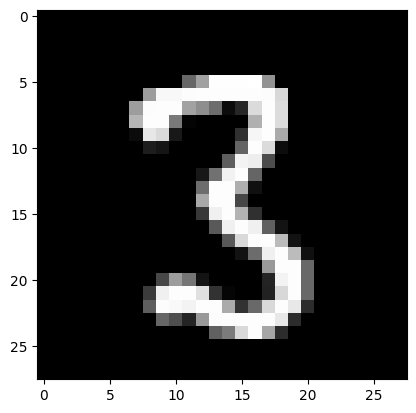

Prediction:  [9]
Label:  3


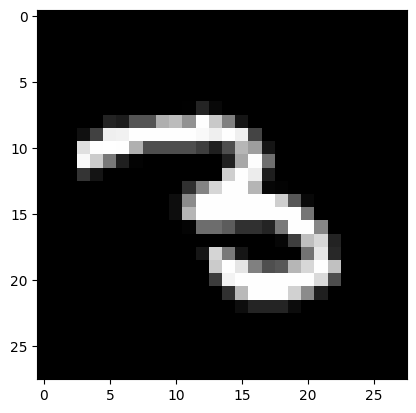

Prediction:  [1]
Label:  1


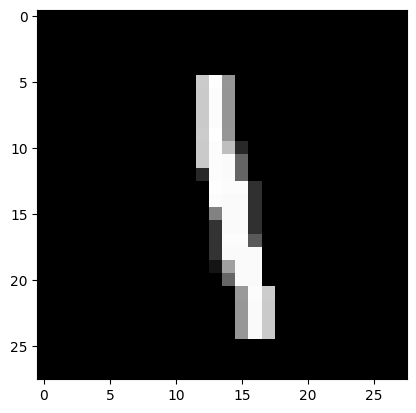

Prediction:  [8]
Label:  8


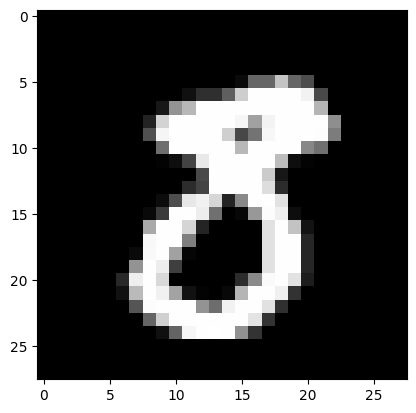

[4 3 4 0 4 2 0 2 5 9 8 0 6 9 0 9 3 4 7 9 2 9 3 7 8 7 3 3 1 1 9 8 8 4 7 4 3
 2 8 8 1 4 5 6 5 2 6 9 5 1 6 8 8 9 9 5 5 2 1 8 4 6 0 1 7 4 1 8 7 1 3 2 0 5
 2 7 2 6 2 5 6 3 8 8 5 2 5 8 3 7 9 9 3 3 3 3 1 6 3 4 7 6 6 0 6 6 5 9 0 2 6
 5 3 2 0 0 1 3 1 7 2 8 5 8 9 1 6 1 0 3 9 7 1 4 4 2 8 7 5 6 2 3 2 7 5 9 6 5
 0 9 1 7 0 6 3 2 0 9 9 4 5 2 4 7 4 8 4 2 0 3 4 9 7 6 4 3 6 4 6 1 2 8 5 5 2
 9 0 8 2 2 4 2 6 1 7 6 7 9 4 1 8 3 6 3 1 6 7 1 3 1 6 4 3 2 7 1 9 8 2 9 3 9
 1 6 5 1 7 1 6 9 8 9 2 9 2 9 8 9 8 6 1 5 2 9 0 9 6 0 3 1 9 6 3 1 9 4 5 4 2
 9 9 2 6 2 1 2 7 5 2 9 9 1 8 7 7 7 6 7 8 3 0 6 4 3 6 2 6 4 7 6 7 1 2 8 0 9
 9 7 6 0 1 4 1 4 6 8 3 2 6 7 7 6 7 6 3 7 1 3 8 7 3 7 1 8 7 9 9 8 6 8 5 7 6
 0 4 1 3 6 5 5 8 7 0 3 0 9 9 9 0 8 5 2 8 5 8 1 8 5 9 3 1 4 6 9 5 1 2 4 8 2
 1 8 9 3 2 6 6 4 2 4 9 2 4 3 0 9 7 4 2 0 9 2 3 4 4 0 1 5 8 9 8 7 9 0 5 4 9
 0 1 7 0 8 9 2 4 1 8 9 3 0 1 8 2 5 7 6 5 6 9 9 1 4 6 6 0 6 9 7 7 4 9 9 7 9
 9 6 5 3 9 4 1 1 1 6 8 4 4 0 9 9 1 0 4 8 3 7 7 7 7 5 4 6 1 2 4 0 5 5 8 7 0
 6 3 4 8 9 6 7 9 8 2 2 8 

0.876

In [7]:
#run forward_prop and identify the max value position in A2
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

#make a prediction for one instance in X. Compare it to its label and show its image
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
    
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

#run predictions on test data
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)